Group Members: Dhruv, Rohan, Sarthak, Uday

In [ ]:
# !pip install yahoofinance
# !pip install hmmlearn

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
from hmmlearn import hmm
import matplotlib.pyplot as plt
import sys
import os
sys.path.append(os.getcwd() + '/modules')
import seaborn as sns

from modules.detect_directional_change import get_dc_data_v2


plt.style.use('seaborn')
sns.set_theme()

# Data Preprocessing

## Reading data

In [2]:
TYPE = 'bond' # 'equity' or 'fx' or 'bond'

TICKER_MAPPER = {'equity':['^DJI','^GSPC','^IXIC'],
                'bond':['^TNX', '^IRX'],
                'fx':['RUB=X','GBP=X','JPY=X']}

TICKERS = TICKER_MAPPER[TYPE]
START_DATE = "2005-01-01"
THETA = 0.005
NUM_REGIMES = 2

TRADING_DAY = {'equity':6.5, 'fx':12,'bond':9} # number of hours in a day we offset
TEST_TICKER = TICKERS[-1] # if we need to debug for a single ticker

TODO: THETA has to depend on instrument considered, curencies are relatively more stable than equities

In [3]:
data = yf.download(TICKERS, start=START_DATE, end = '2022-12-31') # time series data
df_ts_close = data['Adj Close'].dropna()
df_ts_open = data['Open'].dropna()
df_ts_open.index = df_ts_open.index + pd.Timedelta(f'{TRADING_DAY[TYPE]/2}h') # adjust time
df_ts = pd.concat([df_ts_close,df_ts_open]).sort_index()

[*********************100%***********************]  3 of 3 completed


In [801]:
df_ts.pct_change().describe()

,^DJI,^GSPC,^IXIC
count,9061.000000,9061.000000,9061.000000
mean,0.000209,0.000219,0.000278
std,0.012987,0.013515,0.014427
min,-0.138348,-0.124082,-0.140664
25%,-0.005315,-0.005447,-0.006284
50%,0.000128,0.000115,0.000094
75%,0.005850,0.006119,0.007205
max,0.117979,0.126971,0.159344


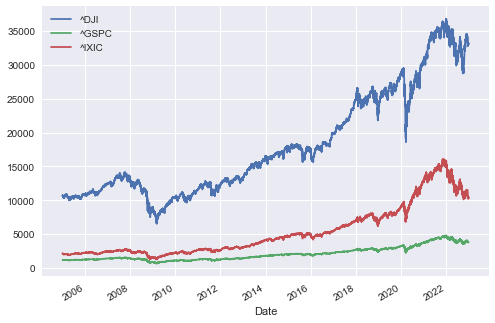

In [802]:
df_ts.plot()

## Generating Directional Change (DC) data

TODO: peaks and troughs are recognized in hindsight

In [803]:
def get_DC_data(data: pd.Series, theta: float) -> tuple[pd.Series]:
    """Returns the Directional Change (DC) data for a given price series.

    Args:
        data (pd.Series): price
        theta (float): threshold

    Returns:
        tuple[pd.Series]: Directional Change Confirmation and Extreme Points (DCC,EXT)
    """

    rets = data.pct_change().dropna().to_numpy() # pct change returns
    DCC = [] # idx for directional change confirmations
    EXT = [] # idx for extreme points

    prev_sign = np.sign(rets[0]).astype(int) # store sign(return) from the previous time step
    accumulated = rets[0] # accumulated % return
    idx_change = 0 # index the direction changes, candidate for EXT
    sign_already_flagged = 0

    for idx,ret in zip(range(1,len(rets)),rets[1:]):
        
        ret_sign = np.sign(ret).astype(int)

        if (ret_sign!=prev_sign):
            # sign is different from previous time step, trend ends
            idx_change = idx-1 # previous price point is a candidate for EXT
            accumulated = ret # reset accumulated sum
            
            
        # same sign
        elif ret_sign != sign_already_flagged:
            # once we flag a threshold, we don't flag it again for the same trend
            # a peak has to be followed by a trough and vice versa
            accumulated += ret
            if np.abs(accumulated) > theta:
                # we cross the threshold
                DCC.append(idx)
                EXT.append(idx_change)
                sign_already_flagged = ret_sign
        
        prev_sign = ret_sign # set the last seen sign to the current sign

    DCC = data.iloc[1:].iloc[DCC]
    EXT = data.iloc[1:].iloc[EXT]

    return (DCC,EXT)

In [804]:
dcc = {}
ext = {}
for ticker in TICKERS:
    dcc[ticker], ext[ticker] = get_DC_data(df_ts[ticker], THETA)

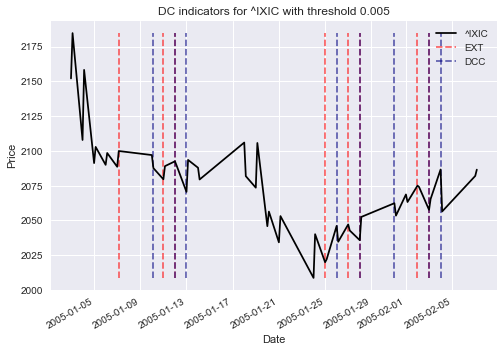

In [805]:
# example
sample_ts = df_ts[TEST_TICKER][:50]
last_date = sample_ts.index[-1]
sample_dcc = dcc[TEST_TICKER].loc[:last_date].index
sample_ext = ext[TEST_TICKER].loc[:last_date].index

fig,ax = plt.subplots()
sample_ts.plot(ax=ax, color ='black')
ymin, ymax = sample_ts.min(), sample_ts.max()
ax.vlines(sample_ext, ymin, ymax, 'r','dashed',label='EXT',alpha=0.6)
ax.vlines(sample_dcc, ymin, ymax, 'navy','dashed',label='DCC',alpha=0.6)
ax.set_title(f"DC indicators for {TEST_TICKER} with threshold {THETA}")
ax.set_ylabel("Price")
ax.legend()
plt.show()

## Directional Change indicators

In [806]:
def get_TMV(ext: pd.Series, theta: float) -> pd.Series:
    """Gets the total price movement (TMV), which is the absolute percentage of the price change in a trend, normalized by the threshold.

    Args:
        ext (pd.Series): extreme points
        theta (float): threshold

    Returns:
        pd.Series: total price movement at respective timestamps
    """
    return ext.pct_change().dropna()/theta

def get_T(ext: pd.Series) -> pd.Series:
    """Gets the time for completion of a TMV trend, in days.

    Args:
        ext (pd.Series): extreme points

    Returns:
        pd.Series: time for completion of trends at respective timestamps
    """
    # extract number of days and hours between extreme points
    t_ext = pd.Series(ext.index).diff().dropna().apply(lambda x: x.days + (x.seconds//3600)/24)
    t_ext.index = ext.index[1:]
    return t_ext

def get_R(tmv: pd.Series, T: pd.Series, theta: float) -> pd.Series:
    """Gets the absolute return (R), which is the time-adjusted return of DC.

    Args:
        tmv (pd.Series): total price movement
        T (pd.Series): time for completion of a trend
        theta (float): threshold

    Returns:
        pd.Series: time-adjusted return of DC
    """
    return tmv*theta/T

In [807]:
tmv = {}
T = {}
R = {}
for ticker in TICKERS:
    tmv[ticker] = get_TMV(ext[ticker],THETA)
    T[ticker] = get_T(ext[ticker])
    R[ticker] = get_R(tmv[ticker],T[ticker],THETA)

# Methods

## Hidden Markov model on DC data

Fitting it on time-adjusted return of DC (R).

Assumptions:

- Gaussian distribution for model density
- Two states

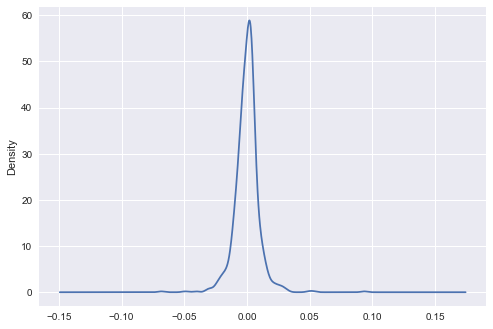

In [808]:
R[TEST_TICKER].plot.density()

TODO:  Note, since the EM algorithm is a gradient-based optimization method, it will generally get stuck in local optima. You should in general try to run fit with various initializations and select the highest scored model.

In [902]:
def fit_hmm(n_components: int, price: pd.Series, indicator: pd.Series, ticker: str, plot: bool =False) -> tuple[pd.Series, hmm.GaussianHMM]:
    """Fits a Hidden Markov model to the data and predicts regimes on it. Optionally makes a plot.

    Args:
        n_components (int): number of regimes
        price (pd.Series): price series of the instrument
        indicator (pd.Series): indicator series we wish to fit the model on
        ticker (str): ticker of the instrument
        plot (bool, optional): whether the regimes need to be plotted. Defaults to False.

    Returns:
        tuple[pd.Series,hmm.GaussianHMM]: the predicted regimes and the HMM model
    """
    
    X = indicator.to_numpy().reshape(-1,1)
    X_train = X[:int(0.7*len(X))] # TODO remove hardcode

    models, scores = [], []
    for idx in range(10):
        model = hmm.GaussianHMM(n_components=2, covariance_type="full", n_iter=1000,
            random_state=idx)
  
        model.fit(X_train)
        models.append(model)
        scores.append(model.score(X))

    model = models[np.argmax(scores)]

    regimes = pd.Series(model.predict(X))
    regimes.index = indicator.index

    if plot:
        fig, ax = plt.subplots()
        price.plot(ax=ax, color='black')
        clr = {0:'grey',1:'red',2:'green'}

        for time_start, time_end, regime in zip(regimes.index[:-1], regimes.index[1:], regimes.values[:-1]):
            ax.axvspan(time_start,time_end, alpha=0.8, color=clr[regime])
        ax.vlines(price.index[int(0.7*len(price))],0,price.max(),color='blue')
        ax.set_title(f"regimes for {ticker}")
        ax.set_ylabel("price")
        plt.show()

    return regimes, model

[*********************100%***********************]  3 of 3 completed


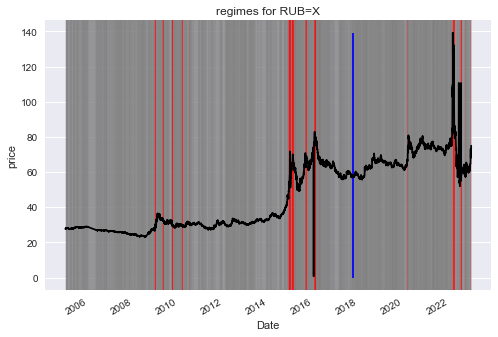

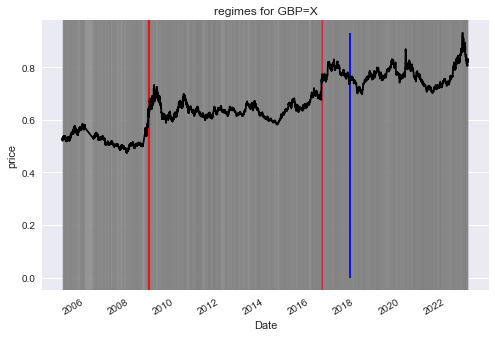

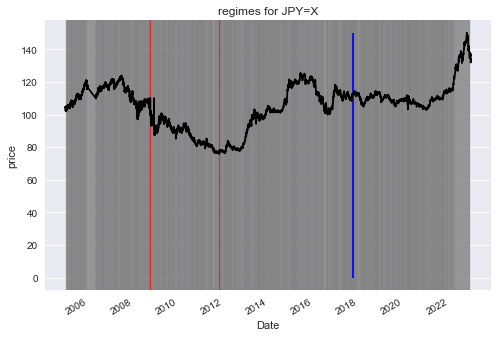

In [903]:
TYPE = 'fx' # 'equity' or 'fx' or 'bond'

TICKER_MAPPER = {'equity':['^DJI','^GSPC','^IXIC'],
                'bond':['^TNX', '^IRX'],
                'fx':['RUB=X','GBP=X','JPY=X']}

TICKERS = TICKER_MAPPER[TYPE]
START_DATE = "2005-01-01"
THETA = 0.001
NUM_REGIMES = 2

TRADING_DAY = {'equity':6.5, 'fx':12,'bond':9} # number of hours in a day we offset
TEST_TICKER = TICKERS[-1] # if we need to debug for a single ticker

data = yf.download(TICKERS, start=START_DATE, end = '2022-12-31') # time series data
df_ts_close = data['Adj Close'].dropna()
df_ts_open = data['Open'].dropna()
df_ts_open.index = df_ts_open.index + pd.Timedelta(f'{TRADING_DAY[TYPE]/2}h') # adjust time
df_ts = pd.concat([df_ts_close,df_ts_open]).sort_index()

dcc = {}
ext = {}
for ticker in TICKERS:
    dcc[ticker], ext[ticker] = get_DC_data(df_ts[ticker], THETA)

tmv = {}
T = {}
R = {}
for ticker in TICKERS:
    tmv[ticker] = get_TMV(ext[ticker],THETA)
    T[ticker] = get_T(ext[ticker])
    R[ticker] = get_R(tmv[ticker],T[ticker],THETA)

for ticker in TICKERS:
    regimes, model = fit_hmm(NUM_REGIMES, df_ts[ticker], R[ticker], ticker, plot = True)


## New version of get_dc_data:

/Users/rohan/opt/anaconda3/envs/py39opt/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/rohan/opt/anaconda3/envs/py39opt/lib/python3.9/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/rohan/opt/anaconda3/envs/py39opt/lib/python3.9/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


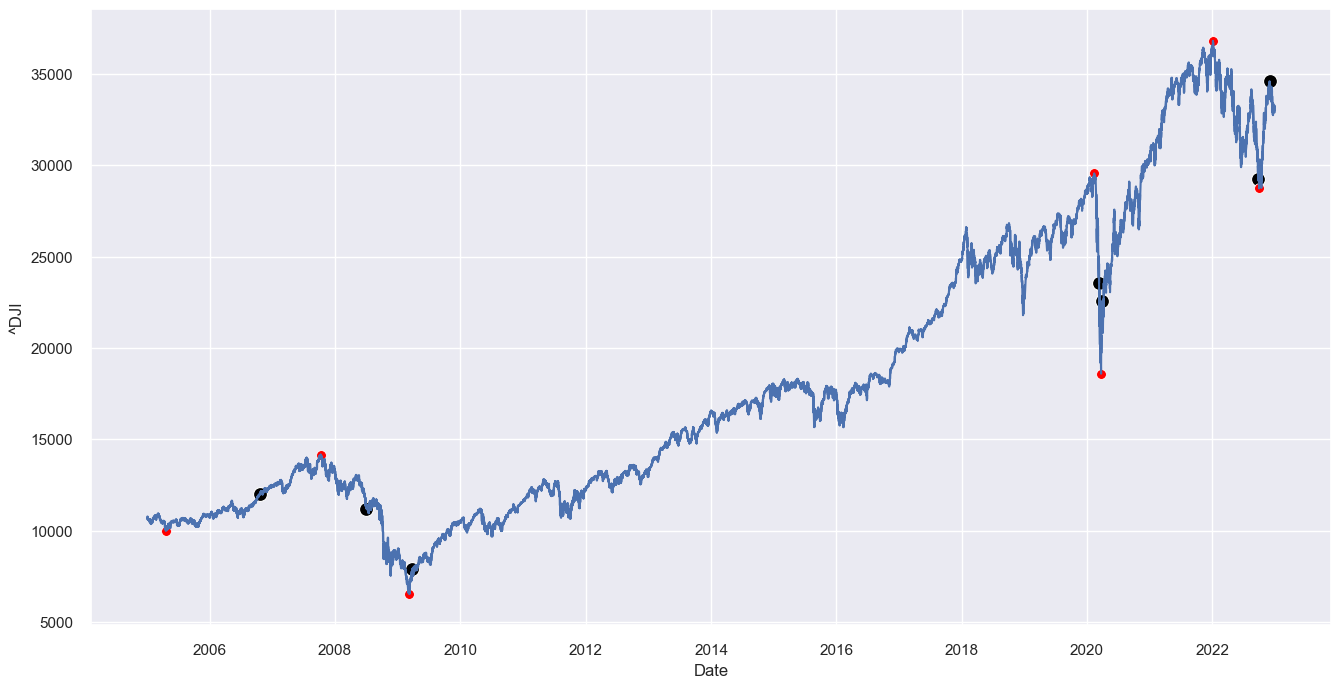

In [4]:
features = get_dc_data_v2(df_ts['^DJI'], 0.2)
fig, ax = plt.subplots(figsize=(16,8))
sns.lineplot(df_ts['^DJI'])
sns.scatterplot(x = [i[0] for i in features], y = [i[1] for i in features], color='black', s=100)
sns.scatterplot(x = [i[2] for i in features], y = [i[3] for i in features], color='red', s=50)
None